In [27]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def Verify(expression, message):
    assert expression

In [28]:
import pandas as pd
import torch

df_train = pd.read_csv('./sign_mnist_train.csv')
df_test = pd.read_csv("./sign_mnist_test.csv")

X_train, y_train = df_train.iloc[:,1:].values/255.0, df_train.iloc[:,0].values #normalizing takes place here
X_test, y_test = df_test.iloc[:,1:].values/255.0, df_test.iloc[:,0].values

from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer() #One hot encoding of the labels
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)

print("X_train numpy shape: "+ str(X_train.shape))
print("X_test numpy shape: " +str(X_test.shape))
print("y_train numpy shape: " +str(y_train.shape))
print("y_test numpy shape: " + str(y_test.shape))


X_train_tensor, y_train_tensor = torch.tensor(X_train).reshape(-1, 28, 28, 1), torch.tensor(y_train) #Reshaped to 2D images for the CNN
X_test_tensor, y_test_tensor = torch.tensor(X_test).reshape(-1,28,28,1), torch.tensor(y_test)

print("X_train tensor shape: "+ str(X_train_tensor.shape))
print("X_test tensor shape: " +str(X_test_tensor.shape))
print("y_train tensor shape: " +str(y_train_tensor.shape))
print("y_test tensor shape: " + str(y_test_tensor.shape))


X_train numpy shape: (27455, 784)
X_test numpy shape: (7172, 784)
y_train numpy shape: (27455, 24)
y_test numpy shape: (7172, 24)
X_train tensor shape: torch.Size([27455, 28, 28, 1])
X_test tensor shape: torch.Size([7172, 28, 28, 1])
y_train tensor shape: torch.Size([27455, 24])
y_test tensor shape: torch.Size([7172, 24])


In [29]:
####THIS CELL IS NOT TO BE USED, PUT HERE SO I CAN LOOK BACK LATER MAYBE####

# class ReLU:
#     def __call__(self, X):
#         return np.maximum(0, X)
    
#     def grad(self, X):
#         return (X > 0).astype(X.dtype)

# ## MLP Implementation uses softmax and a cross entropy loss function
# class MLP:
#     def __init__(self, activation_functor_with_grad, number_of_hidden_layers, number_of_hidden_units : list, input_dimensions=784, output_dimensions = 25, use_bias = True):
#         try:
#             Verify(number_of_hidden_layers == len(number_of_hidden_units), "Hidden layers does not match size of hidden units list.")
#             Verify(callable(activation_functor_with_grad) and hasattr(activation_functor_with_grad, 'grad'), "Activation functor passed must be callable and have a grad method.")

#             self.activator = activation_functor_with_grad
#             self.number_of_hidden_layers = number_of_hidden_layers
#             self.number_of_hidden_units = number_of_hidden_units
#             self.use_bias = use_bias

#             self.dimensions_list = [input_dimensions] + number_of_hidden_units + [output_dimensions]

#             self.weights = []
#             for i in range(len(self.dimensions_list)-1):
#                 self.weights.append(initialize_matrix((self.dimensions_list[i]+self.use_bias, self.dimensions_list[i+1])))

#         except AssertionError as e:
#                 print(f"An error occurred: {e}")

#     def predict(self, input):
#         if self.use_bias:
#             # Adding a bias column of ones to the input if use_bias is True
#             input = np.hstack((input, np.ones((input.shape[0], 1))))
            
#         current_layer = input
#         for weight_matrix in self.weights[:-1]:  # Excluding the last weight matrix so that we can avoid adding the bias to the final output
#             current_layer_unactivated = current_layer @ weight_matrix
#             current_layer = self.activator(current_layer_unactivated)
#             if self.use_bias:
#                 # Add bias term for the next layer
#                 current_layer = np.hstack((current_layer, np.ones((current_layer.shape[0], 1))))

#         # Processing the last layer without adding a bias term again
#         final_unactivated = current_layer @ self.weights[-1]
#         return softmax(self.activator(final_unactivated))
    
#     def grad():
#         #This is hella complicated, trying a different approach.
#         return None

In [30]:

#Need to add early stopping criteria
class GradientDescentOptimizerWithValidation:
    def __init__(self, x_val, y_val, net, lr: float):
        self.net = net
        self.lr = lr
        self.x_val = x_val
        self.y_val = y_val

    def step(self):
        for layer in self.net.layers[::-1]:
            if layer.parameters is not None:
                self.update(layer.parameters, layer.gradient)

    def update(self, params, gradient):
        for (p, g) in zip(params, gradient):
            p -= self.lr * g.mean(axis=0)

In [31]:
#Base class for neural net layers, from: https://colab.research.google.com/github/yueliyl/comp551-notebooks/blob/master/NumpyDeepMLP.ipynb
#Overall approach is very similar to the one taken in most machine learning APIs like TensorFlow and PyTorch
class NeuralNetLayer:
    def __init__(self):
        self.gradient = None
        self.parameters = None
    
    def forward(self, X):
        raise NotImplementedError
    
    def backward(self, gradient):
        raise NotImplementedError
    

#Linear Layer implementation, with gaussian initialization
class LinearLayer(NeuralNetLayer):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.ni = input_size
        self.no = output_size
        self.w = np.random.randn(output_size, input_size)
        self.b = np.random.randn(output_size)
        self.cur_input = None
        self.parameters = [self.w, self.b]

    def forward(self, x):
        self.cur_input = x
        return (self.w[None, :,:] @ x[:,:,None]).squeeze() + self.b #Clever notation from the collab to deal with dimensions -> Final output is output_sizex1
    
    def backward(self, gradient):
        Verify(self.cur_input is not None, "Must call forawrd before backward")
        dw = gradient[:,:,None] @ self.cur_input[:,None,:] #Derivative with respect to the weight is the input, so we multiply the backpropped gradient by the current input
        db = gradient #Derivative with respect to b is 1, so we just keep the previous gradient
        self.gradient = [dw, db]
        return gradient.dot(self.w)
    

#ReLU Layer implementation
class ReLULayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
    
    #The gradient depends on what is passed in due to the discontinuity
    def forward(self, x):
        self.gradient = np.where(x>0, 1.0, 0.0) #Gradient is 1 for input greater than 0, otherwise its 0
        return np.maximum(0, x)
    
    def backward(self,gradient):
        Verify(self.gradient is not None, "Must call forward before backward")
        return gradient *self.gradient

    def copy(self):
        return ReLULayer()
    
#Softmax layer - gradient only valid for use with cross entropy loss
class SoftmaxOutputLayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        self.cur_probs = None
    
    def forward(self, x):
        exps = np.exp(x)
        probs = exps / np.sum(exps, axis=-1)[:, None]
        self.cur_probs = probs
        return probs
    
    def backward(self, target):
        Verify(self.cur_probs is not None, "Must call forward before backward")
        return self.cur_probs - target #Really simple gradient form when softmax is combined with cross entropy loss function        

In [37]:
import copy

class MLP:
    def __init__(self, activation_functor, number_of_hidden_layers, number_of_hidden_units : list, input_dimensions=784, output_dimensions = 24):
        Verify(number_of_hidden_layers == len(number_of_hidden_units), "Hidden layers does not match size of hidden units list.")

        self.activator = activation_functor
        self.number_of_hidden_layers = number_of_hidden_layers
        self.number_of_hidden_units = number_of_hidden_units

        self.dimensions_list = [input_dimensions] + number_of_hidden_units + [output_dimensions]
        self.layers = []
        for i in range(len(self.dimensions_list)-1):
            self.layers.append(LinearLayer(self.dimensions_list[i], self.dimensions_list[i+1]))
            self.layers.append(activation_functor.copy())
        self.layers.append(SoftmaxOutputLayer()) #Final layer is a softmax
    
    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def backward(self, target):
        for layer in self.layers[::-1]:
            target = layer.backward(target) #target points to the gradients now

    #Just a wrapper for convenience with other code
    def predict(self, x):
        return self.forward(x)
    
    def copy(self):
        return copy.deepcopy(self)
    
    def fit(self, x, y, max_iter, lr):
        self.lr = lr
        
        #First split into train/validation split
        np.random.seed(13) #So that its deterministic
        val_size = int(len(x) * 0.2)  # For an 80/20 split
        indices = np.arange(len(x))
        np.random.shuffle(indices)
        val_indices = indices[:val_size]
        train_indices = indices[val_size:]
        # Use the indices to create training and validation sets
        x_train, y_train = x[train_indices], y[train_indices]
        x_val, y_val = x[val_indices], y[val_indices]

        val_losses = []
        val_labels = y_val.copy()
        val_pred = self.forward(x_val)
        val_loss = -(val_labels * np.log(val_pred)).sum(axis=-1).mean()
        val_losses.append(val_loss) #need a first value to compare to
        best_mlp = self.copy()

        train_losses = []
        train_labels = y_train.copy() #y is already one hot encoded

        for i in tqdm(range(max_iter)):

            if (i%1==0): #At every step, idk if this will work if its not at every step
                val_pred = self.forward(x_val)
                val_loss = -(val_labels * np.log(val_pred)).sum(axis=-1).mean() #Cross entropy
                val_losses.append(val_loss)

                if val_loss<min(val_losses[:-1]):
                    best_mlp = self.copy()

            train_pred = self.forward(x_train)
            loss = -(train_labels * np.log(train_pred)).sum(axis=-1).mean() #Cross entropy
            train_losses.append(loss)
            self.backward(train_labels) #labels now points to gradient
            
            #We take step now
            for layer in self.layers[::-1]:
                if layer.parameters is not None:
                    for (p, g) in zip(layer.parameters, layer.gradient):
                        p -= self.lr*g.mean(axis=0)

        plt.figure(figsize=(10, 6))
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel("Epochs")
        plt.ylabel("Cross-entropy Loss")
        plt.yscale('log')
        plt.title("Training and Validation Losses")
        plt.legend()
        plt.show()

        #Return best performing model on the validation set
        return best_mlp

In [33]:
def evaluate_accuracy(y_true_onehot, predicted_probabilities):
    # Convert one-hot encoded true labels to class indices
    y_true_indices = np.argmax(y_true_onehot, axis=1)
    
    # Convert predicted probabilities to predicted class indices
    predicted_indices = np.argmax(predicted_probabilities, axis=1)
    
    # Calculate accuracy as the mean of correct predictions
    accuracy = np.mean(y_true_indices == predicted_indices)
    
    return accuracy

100%|██████████| 500/500 [12:17<00:00,  1.47s/it]


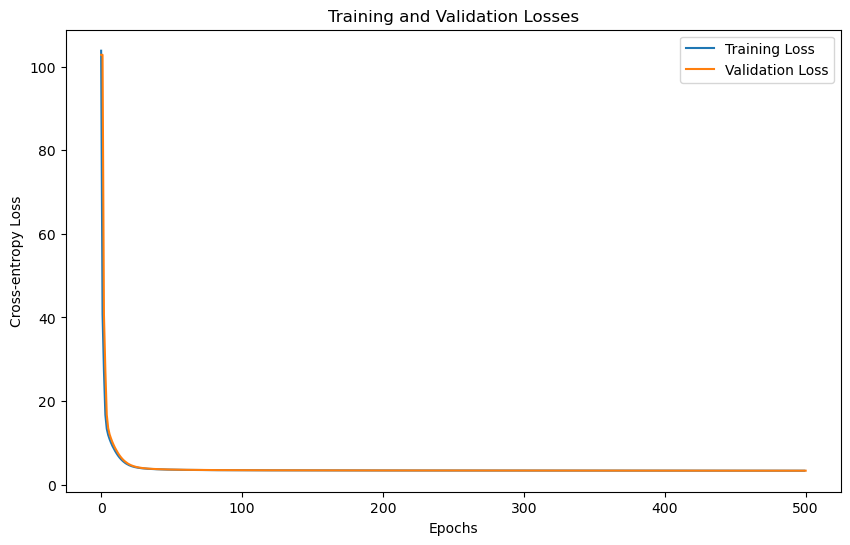

In [39]:
relu = ReLULayer()
mlp1 = MLP(relu, 2, [10,10])

mlp1_fitted = mlp1.fit(X_train, y_train, 500, 0.01)


In [40]:
predictions_test = mlp1_fitted.predict(X_test)
print(f"Test Accuracy: {evaluate_accuracy(y_test, predictions_test)*100}%")

Test Accuracy: 4.043502509760179%
